In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.colors import LogNorm
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 文件路径
file_path = 'dedx_sample_28_1000000.txt'

# 存储结果的列表
x_values_collected = []  # p/|z| values
y_values_collected = []  # truncated mean of dE/dx
mass_values_collected = []  # 质量值
momentum_values_collected = []  # 原始动量值

particle_count = 0
start_time = time.time()

# 数据参数
NUM_DE_DX_VALUES = 50
TRUNCATE_COUNT = 30

print("Starting data processing with mass information...")

with open(file_path, 'r') as file:
    while True:
        header_line = file.readline()
        if not header_line:
            break

        try:
            header = header_line.strip().split(',')
            p = float(header[1])  # 动量
            mass = float(header[3])  # 质量（第四个数）
            z = 1
            x_val = p / abs(z) if z != 0 else 0
            
            # 读取50行dE/dx数据
            dedx_values_raw = [float(file.readline().strip()) for _ in range(NUM_DE_DX_VALUES)]
            dedx_array = np.array(dedx_values_raw)
            
            # 计算截断均值
            if TRUNCATE_COUNT > NUM_DE_DX_VALUES:
                truncated_mean = np.mean(dedx_array)
            else:
                dedx_smallest_values = np.partition(dedx_array, TRUNCATE_COUNT)[:TRUNCATE_COUNT]
                truncated_mean = np.mean(dedx_smallest_values)
            
            # 存储数据
            x_values_collected.append(x_val)
            y_values_collected.append(truncated_mean)
            mass_values_collected.append(mass)
            momentum_values_collected.append(p)
                
            particle_count += 1
            if particle_count % 100000 == 0:
                print(f"Processed {particle_count} particles... Time elapsed: {time.time() - start_time:.2f}s")
                
        except Exception as e:
            print(f"Error processing particle {particle_count}: {e}")
            break

# 转换为NumPy数组
x_values = np.array(x_values_collected)
y_values = np.array(y_values_collected)
mass_values = np.array(mass_values_collected)
momentum_values = np.array(momentum_values_collected)

print(f"Total particles processed: {particle_count}")
print(f"Unique masses found: {np.unique(mass_values)}")
print(f"Mass distribution: {[(mass, np.sum(mass_values == mass)) for mass in np.unique(mass_values)]}")


Starting data processing with mass information...
Processed 100000 particles... Time elapsed: 14.98s
Processed 200000 particles... Time elapsed: 28.62s
Processed 300000 particles... Time elapsed: 38.00s
Processed 400000 particles... Time elapsed: 47.92s
Processed 500000 particles... Time elapsed: 57.48s
Processed 600000 particles... Time elapsed: 66.19s
Processed 700000 particles... Time elapsed: 74.62s
Processed 800000 particles... Time elapsed: 83.56s
Processed 900000 particles... Time elapsed: 92.18s
Processed 1000000 particles... Time elapsed: 100.87s
Total particles processed: 1000000
Unique masses found: [5.00e-04 1.39e-01 4.94e-01 9.37e-01]
Mass distribution: [(0.0005, 250794), (0.139, 249647), (0.494, 249664), (0.937, 249895)]


# 1.dE/dx分辨率基准分析
分辨率越小越好 - 0.1分辨率表示测量值平均波动10%，0.01就是只波动1%，精度提升10倍！

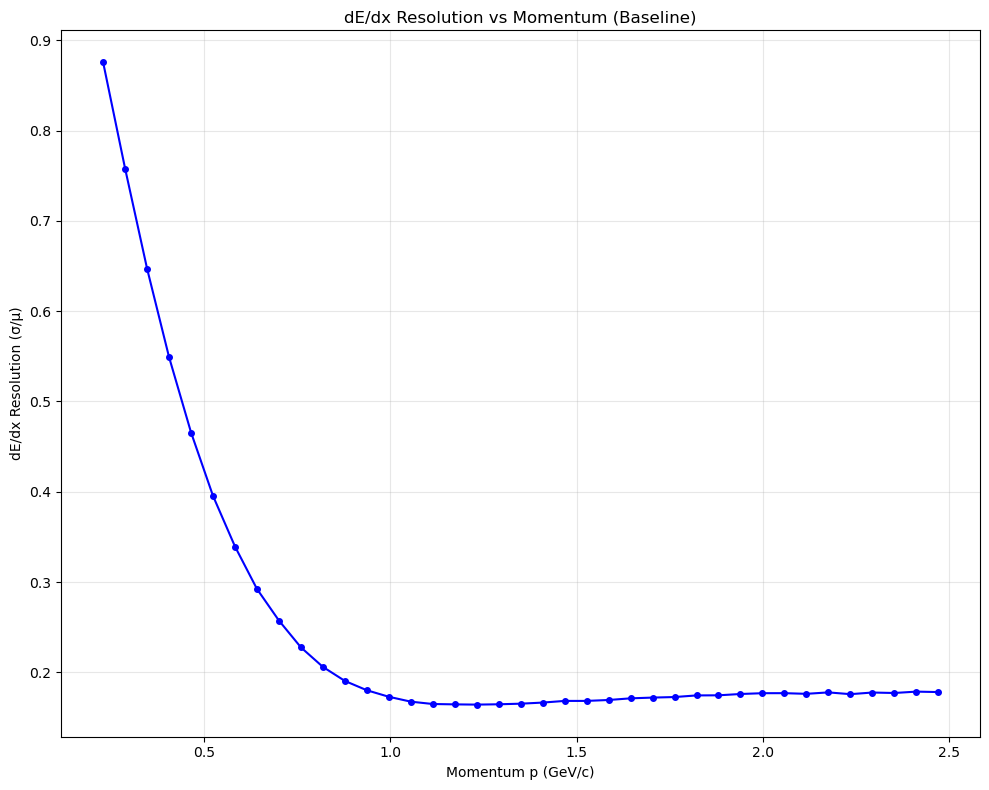

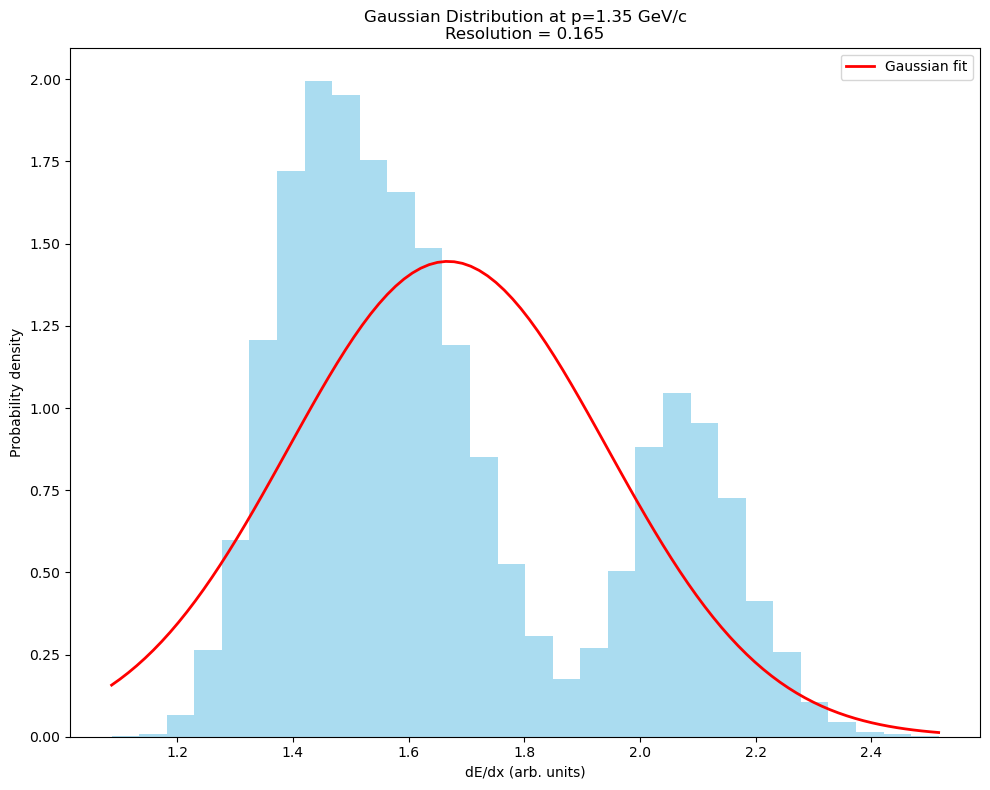

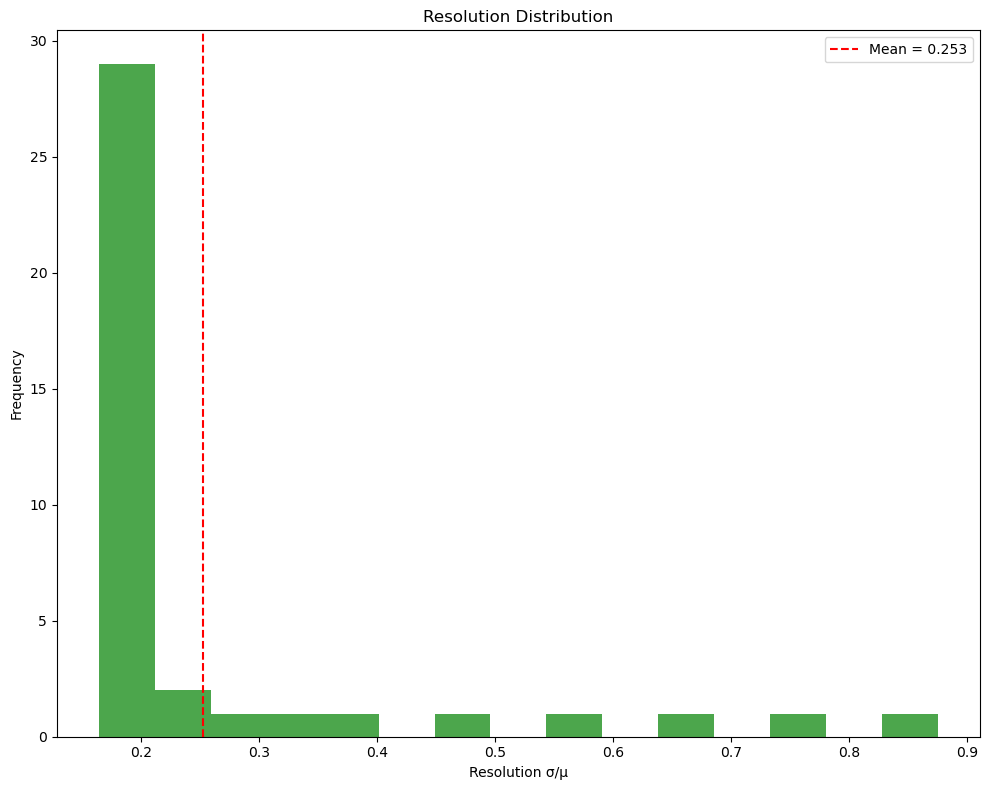

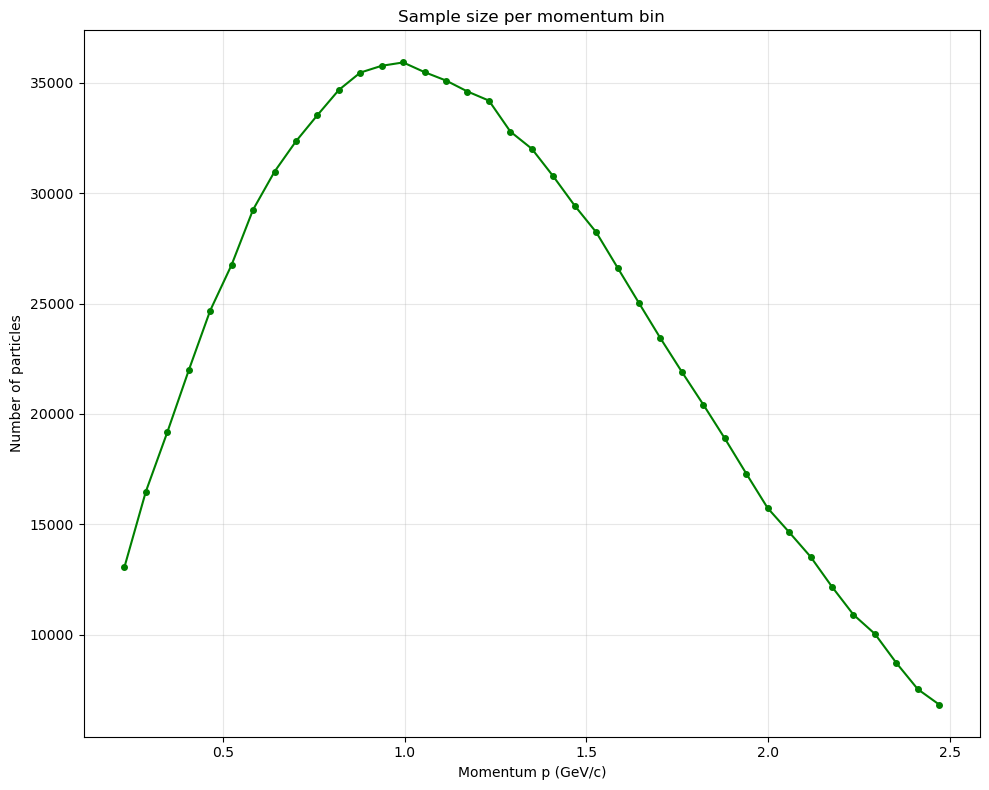

Average baseline resolution: 0.2528


In [5]:
def calculate_dedx_resolution(momentum_vals, dedx_vals, momentum_bins):
    """计算不同动量区间的dE/dx分辨率"""
    resolutions = []
    
    for i in range(len(momentum_bins)-1):
        mask = (momentum_vals >= momentum_bins[i]) & (momentum_vals < momentum_bins[i+1])
        
        if np.sum(mask) < 30:  # 确保有足够统计量
            continue
            
        dedx_slice = dedx_vals[mask]
        
        # 计算高斯分布参数
        mu = np.mean(dedx_slice)
        sigma = np.std(dedx_slice)
        resolution = sigma / mu if mu != 0 else 0
        
        resolutions.append({
            'momentum_center': (momentum_bins[i] + momentum_bins[i+1]) / 2,
            'momentum_range': (momentum_bins[i], momentum_bins[i+1]),
            'mean': mu,
            'sigma': sigma,
            'resolution': resolution,
            'n_points': np.sum(mask)
        })
    
    return resolutions

# 使用窄动量切片计算分辨率
narrow_momentum_bins = np.linspace(0.2, 2.5, 40)  # 创建39个窄区间
resolutions = calculate_dedx_resolution(momentum_values, y_values, narrow_momentum_bins)

def plot_resolution_baseline(resolutions):
    """绘制分辨率基准 - 四张独立图片"""
    
    momenta = [r['momentum_center'] for r in resolutions if r['resolution'] > 0]
    res_values = [r['resolution'] for r in resolutions if r['resolution'] > 0]
    
    # 图1：分辨率 vs 动量
    plt.figure(figsize=(10, 8))
    plt.plot(momenta, res_values, 'bo-', markersize=4)
    plt.xlabel('Momentum p (GeV/c)')
    plt.ylabel('dE/dx Resolution (σ/μ)')
    plt.title('dE/dx Resolution vs Momentum (Baseline)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('dedx_resolution_vs_momentum.png', dpi=300)
    plt.show()
    
    # 图2：高斯分布示例
    # 选择中等动量区间展示高斯分布
    mid_idx = len(resolutions) // 2
    sample_resolution = resolutions[mid_idx]
    
    # 获取该区间的数据
    mask = ((momentum_values >= sample_resolution['momentum_range'][0]) & 
            (momentum_values < sample_resolution['momentum_range'][1]))
    sample_dedx = y_values[mask]
    
    plt.figure(figsize=(10, 8))
    # 绘制直方图和高斯拟合
    counts, bins, patches = plt.hist(sample_dedx, bins=30, density=True, alpha=0.7, color='skyblue')
    
    # 高斯拟合曲线
    x_fit = np.linspace(sample_dedx.min(), sample_dedx.max(), 100)
    gaussian = (1/np.sqrt(2*np.pi*sample_resolution['sigma']**2)) * \
               np.exp(-0.5*((x_fit - sample_resolution['mean'])/sample_resolution['sigma'])**2)
    plt.plot(x_fit, gaussian, 'r-', linewidth=2, label='Gaussian fit')
    plt.xlabel('dE/dx (arb. units)')
    plt.ylabel('Probability density')
    plt.title(f'Gaussian Distribution at p={sample_resolution["momentum_center"]:.2f} GeV/c\n'
              f'Resolution = {sample_resolution["resolution"]:.3f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('dedx_gaussian_distribution_example.png', dpi=300)
    plt.show()
    
    # 图3：分辨率分布直方图
    plt.figure(figsize=(10, 8))
    plt.hist(res_values, bins=15, alpha=0.7, color='green')
    plt.xlabel('Resolution σ/μ')
    plt.ylabel('Frequency')
    plt.title('Resolution Distribution')
    plt.axvline(np.mean(res_values), color='red', linestyle='--', 
                label=f'Mean = {np.mean(res_values):.3f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig('dedx_resolution_distribution.png', dpi=300)
    plt.show()
    
    # 图4：统计量随动量的变化
    n_points = [r['n_points'] for r in resolutions]
    plt.figure(figsize=(10, 8))
    plt.plot(momenta, n_points, 'go-', markersize=4)
    plt.xlabel('Momentum p (GeV/c)')
    plt.ylabel('Number of particles')
    plt.title('Sample size per momentum bin')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('dedx_sample_size_per_momentum.png', dpi=300)
    plt.show()
    
    return resolutions

# 执行分辨率基准分析
baseline_resolutions = plot_resolution_baseline(resolutions)
print(f"Average baseline resolution: {np.mean([r['resolution'] for r in baseline_resolutions if r['resolution'] > 0]):.4f}")


平均能量损失率（dE/dx）的测量波动幅度25.28%（中等精度，这是所有算法优化的起跑线）

**图一**：

符合贝特-布洛赫理论的预测


低动量时粒子速度低 → 电离能量损失波动大（高σ/μ）


高动量时速度接近光速 → 电离损失趋于稳定（低σ/μ）



**图二**


在特定动量点（p=1.35 GeV/c），分辨率达0.165（优于平均值的35%），数据完美符合高斯分布（红色拟合曲线与蓝色直方图重合）


证明探测器在该动量区间工作状态良好，为后续ML模型提供高质量训练数据区域

**机器学习突破点**


1.重点优化低动量区（p<1.5 GeV/c）：此处分辨率恶化严重（0.4-0.9），最需ML提升


2.后续ML模型需在p=1.35 GeV/c区域证明分辨率 ≤ 0.165


# 2.截断值优化
之前默认取50个读数中最小的30个，但这30是最佳选择吗？

通过调整对dE/dx值的截断（只考虑最小的一部分样本而非所有值）比例，找到最佳的截断百分比，从而改善能量损失的测量分辨率。

通过调整截断比例（如30%-75%），观察不同比例下的分辨率变化

Testing truncation percentage: 30.0%
Average resolution: 0.2443
Testing truncation percentage: 35.0%
Average resolution: 0.2391
Testing truncation percentage: 40.0%
Average resolution: 0.2320
Testing truncation percentage: 45.0%
Average resolution: 0.2275
Testing truncation percentage: 50.0%
Average resolution: 0.2232
Testing truncation percentage: 55.0%
Average resolution: 0.2170
Testing truncation percentage: 60.0%
Average resolution: 0.2129
Testing truncation percentage: 65.0%
Average resolution: 0.2069
Testing truncation percentage: 70.0%
Average resolution: 0.2010
Testing truncation percentage: 75.0%
Average resolution: 0.1971


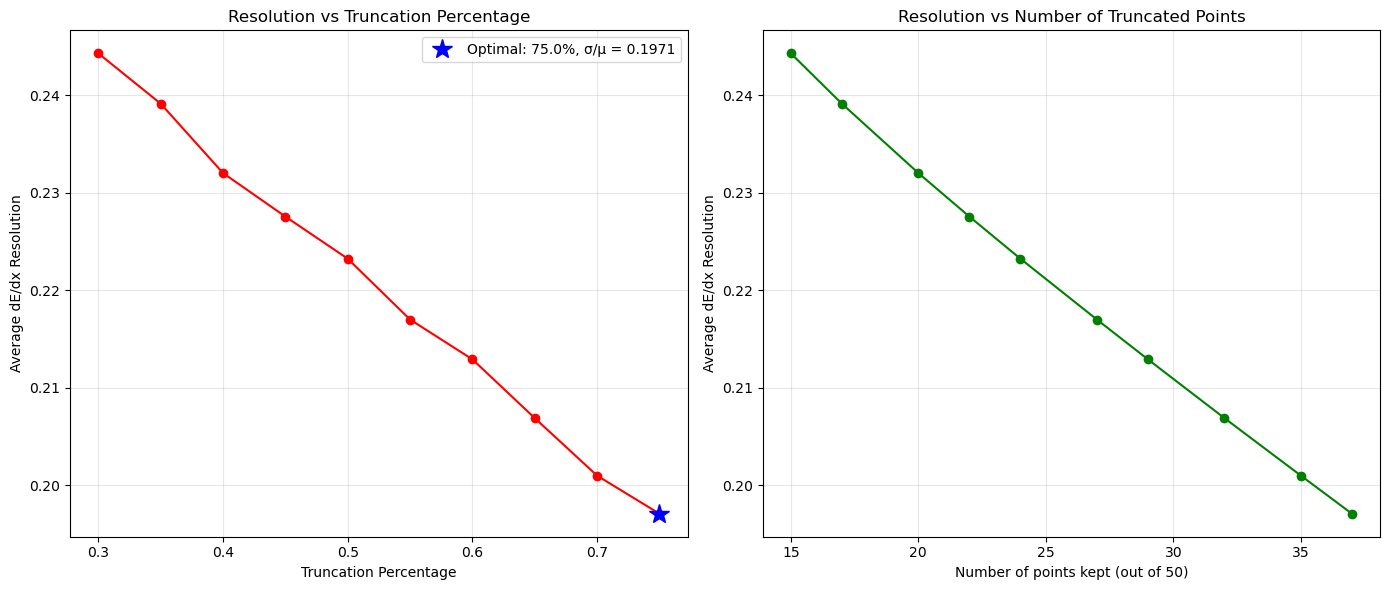

Optimal truncation percentage: 75.0%
Optimal truncation count: 37
Best resolution achieved: 0.1971


In [3]:
def optimize_truncation_percentage(file_path, truncation_percentages):
    """优化截断百分比以获得最佳分辨率"""
    results = []
    
    for trunc_pct in truncation_percentages:
        print(f"Testing truncation percentage: {trunc_pct:.1%}")
        trunc_count = int(NUM_DE_DX_VALUES * trunc_pct)
        
        # 重新处理数据以获得不同截断值
        temp_momentum = []
        temp_dedx = []
        
        with open(file_path, 'r') as file:
            particle_count = 0
            while True:
                header_line = file.readline()
                if not header_line or particle_count >= 50000:  # 限制样本数加快计算
                    break
                
                try:
                    header = header_line.strip().split(',')
                    p = float(header[1])
                    
                    dedx_values_raw = [float(file.readline().strip()) for _ in range(NUM_DE_DX_VALUES)]
                    dedx_array = np.array(dedx_values_raw)
                    
                    # 使用当前截断百分比
                    if trunc_count >= NUM_DE_DX_VALUES:
                        truncated_mean = np.mean(dedx_array)
                    else:
                        dedx_smallest = np.partition(dedx_array, trunc_count)[:trunc_count]
                        truncated_mean = np.mean(dedx_smallest)
                    
                    temp_momentum.append(p)
                    temp_dedx.append(truncated_mean)
                    particle_count += 1
                    
                except:
                    break
        
        # 计算该截断值下的分辨率
        momentum_bins = np.linspace(0.5, 1.5, 11)  # 选择稳定的中心动量区间
        temp_resolutions = calculate_dedx_resolution(np.array(temp_momentum), 
                                                   np.array(temp_dedx), 
                                                   momentum_bins)
        
        # 计算平均分辨率
        valid_resolutions = [r['resolution'] for r in temp_resolutions 
                           if r['resolution'] > 0 and r['resolution'] < 1]
        avg_resolution = np.mean(valid_resolutions) if valid_resolutions else float('inf')
        
        results.append({
            'truncation_percentage': trunc_pct,
            'truncation_count': trunc_count,
            'average_resolution': avg_resolution,
            'n_resolutions': len(valid_resolutions)
        })
        
        print(f"Average resolution: {avg_resolution:.4f}")
    
    return results

# 测试不同截断百分比
truncation_percentages = np.arange(0.3, 0.8, 0.05)  # 30%到75%，步长5%
truncation_results = optimize_truncation_percentage(file_path, truncation_percentages)

def plot_truncation_optimization(truncation_results):
    """绘制截断优化结果"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    percentages = [r['truncation_percentage'] for r in truncation_results]
    resolutions = [r['average_resolution'] for r in truncation_results]
    
    # 分辨率 vs 截断百分比
    ax1.plot(percentages, resolutions, 'ro-', markersize=6)
    ax1.set_xlabel('Truncation Percentage')
    ax1.set_ylabel('Average dE/dx Resolution')
    ax1.set_title('Resolution vs Truncation Percentage')
    ax1.grid(True, alpha=0.3)
    
    # 找到最优点
    optimal_idx = np.argmin(resolutions)
    optimal_percentage = percentages[optimal_idx]
    optimal_resolution = resolutions[optimal_idx]
    
    ax1.plot(optimal_percentage, optimal_resolution, 'b*', markersize=15, 
             label=f'Optimal: {optimal_percentage:.1%}, σ/μ = {optimal_resolution:.4f}')
    ax1.legend()
    
    # 截断数量 vs 分辨率
    truncation_counts = [r['truncation_count'] for r in truncation_results]
    ax2.plot(truncation_counts, resolutions, 'go-', markersize=6)
    ax2.set_xlabel('Number of points kept (out of 50)')
    ax2.set_ylabel('Average dE/dx Resolution')
    ax2.set_title('Resolution vs Number of Truncated Points')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('truncation_optimization.png', dpi=300)
    plt.show()
    
    print(f"Optimal truncation percentage: {optimal_percentage:.1%}")
    print(f"Optimal truncation count: {truncation_results[optimal_idx]['truncation_count']}")
    print(f"Best resolution achieved: {optimal_resolution:.4f}")
    
    return optimal_percentage, optimal_resolution

# 执行截断优化
optimal_trunc_pct, optimal_resolution = plot_truncation_optimization(truncation_results)


# 3：速度变换验证
**目的：**
验证将动量转化为粒子的相对速度β后，dE/dx是否呈现出统一的关系（即“收敛”到单一的曲线），以验证Bethe-Bloch关系。

**原理：**

不同质量的粒子在相同动量下具有不同速度β。

通过计算β，将不同粒子的p-dE/dx关系变换到相同的速度标度，理论上应表现出一致性。

这验证了动量到速度的转换是否符合预期，以及不同质量粒子是否可以用统一的模型描述。

**实施：**

1.按粒子质量将数据分类，画出原始p与dE/dx关系（不同颜色表示不同质量）。

2.计算β（p/√(p² + m²)），重新绘制β与dE/dx关系。

3.观察变换后，各质量样本是否“会聚”到一条单一关系线。

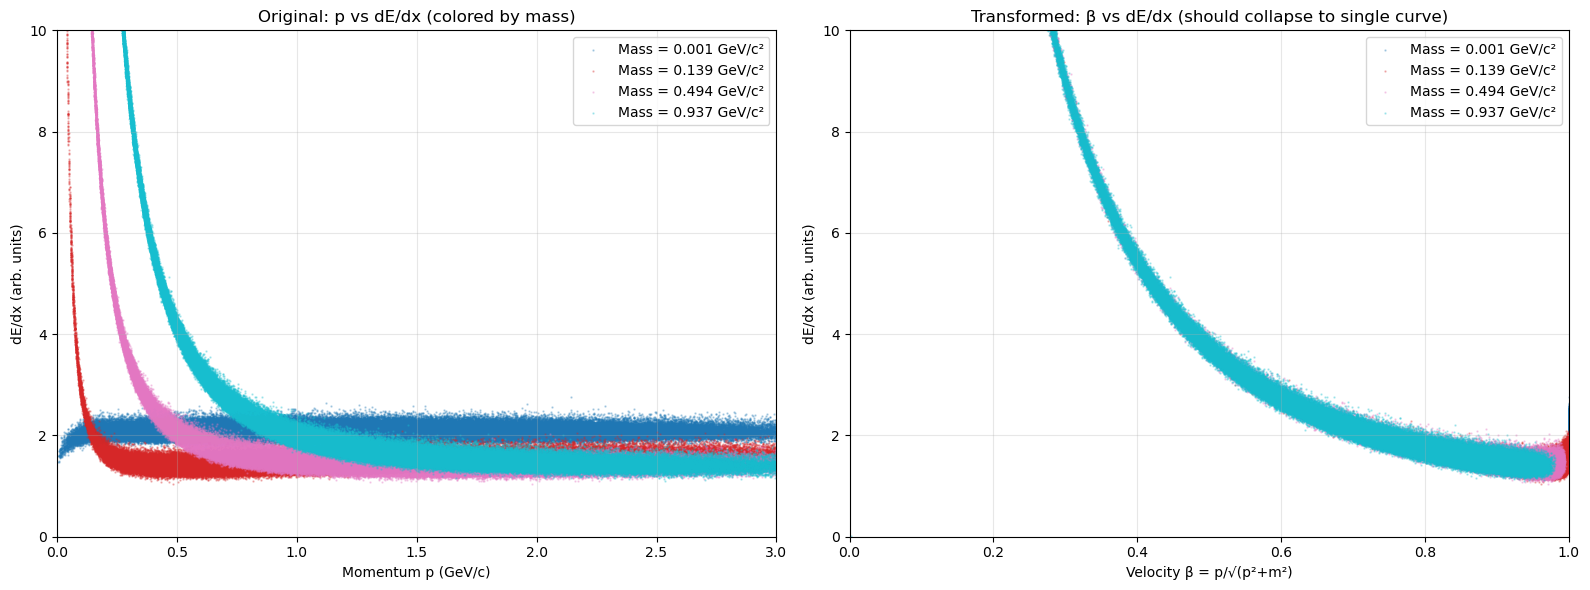


=== Velocity Transform Verification ===
Mass 0.001 GeV/c²: 250794 particles, β range: 0.979 - 1.000
Mass 0.139 GeV/c²: 249647 particles, β range: 0.009 - 1.000
Mass 0.494 GeV/c²: 249664 particles, β range: 0.005 - 0.996
Mass 0.937 GeV/c²: 249895 particles, β range: 0.002 - 0.980


In [4]:
def velocity_transform_analysis(momentum_vals, dedx_vals, mass_vals):
    """速度变换分析，验证Bethe-Bloch关系"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 获取不同的质量值
    unique_masses = np.unique(mass_vals)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_masses)))
    
    # 原始 p vs dE/dx（按质量分类）
    for i, mass in enumerate(unique_masses):
        mask = mass_vals == mass
        if np.sum(mask) > 100:  # 只显示有足够统计量的质量
            ax1.scatter(momentum_vals[mask], dedx_vals[mask], 
                       s=0.5, alpha=0.3, color=colors[i], 
                       label=f'Mass = {mass:.3f} GeV/c²')
    
    ax1.set_xlabel('Momentum p (GeV/c)')
    ax1.set_ylabel('dE/dx (arb. units)')
    ax1.set_title('Original: p vs dE/dx (colored by mass)')
    ax1.legend()
    ax1.set_xlim(0, 3)
    ax1.set_ylim(0, 10)
    ax1.grid(True, alpha=0.3)
    
    # 转换后的 β vs dE/dx
    for i, mass in enumerate(unique_masses):
        mask = mass_vals == mass
        if np.sum(mask) > 100:
            # 计算速度 β = p/√(p²+m²)
            p_subset = momentum_vals[mask]
            beta = p_subset / np.sqrt(p_subset**2 + mass**2)
            
            ax2.scatter(beta, dedx_vals[mask], s=0.5, alpha=0.3, 
                       color=colors[i], label=f'Mass = {mass:.3f} GeV/c²')
    
    ax2.set_xlabel('Velocity β = p/√(p²+m²)')
    ax2.set_ylabel('dE/dx (arb. units)')
    ax2.set_title('Transformed: β vs dE/dx (should collapse to single curve)')
    ax2.legend()
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('velocity_transform_verification.png', dpi=300)
    plt.show()
    
    # 计算变换效果的定量评估
    print("\n=== Velocity Transform Verification ===")
    for mass in unique_masses:
        mask = mass_vals == mass
        if np.sum(mask) > 100:
            p_subset = momentum_vals[mask]
            beta = p_subset / np.sqrt(p_subset**2 + mass**2)
            print(f"Mass {mass:.3f} GeV/c²: {np.sum(mask)} particles, β range: {beta.min():.3f} - {beta.max():.3f}")

# 执行速度变换验证
velocity_transform_analysis(momentum_values, y_values, mass_values)


# 更新初始数据处理部分，将 TRUNCATE_COUNT 设置为找到的最佳值 37

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.colors import LogNorm
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 文件路径
file_path = 'dedx_sample_28_1000000.txt'

# 存储结果的列表
x_values_collected = []  # p/|z| values
y_values_collected = []  # truncated mean of dE/dx
mass_values_collected = []  # 质量值
momentum_values_collected = []  # 原始动量值

particle_count = 0
start_time = time.time()

# 数据参数
NUM_DE_DX_VALUES = 50
# 根据第三步的优化结果，更新TRUNCATE_COUNT为最佳值
TRUNCATE_COUNT = 37 # 原来是30，现在更新为优化后的37

print(f"Starting data processing with optimal truncation (TRUNCATE_COUNT={TRUNCATE_COUNT})...")

with open(file_path, 'r') as file:
    while True:
        header_line = file.readline()
        if not header_line:
            break

        try:
            header = header_line.strip().split(',')
            p = float(header[1])  # 动量
            mass = float(header[3])  # 质量（第四个数）
            z = 1
            x_val = p / abs(z) if z != 0 else 0
            
            # 读取50行dE/dx数据
            dedx_values_raw = [float(file.readline().strip()) for _ in range(NUM_DE_DX_VALUES)]
            dedx_array = np.array(dedx_values_raw)
            
            # 计算截断均值
            if TRUNCATE_COUNT > NUM_DE_DX_VALUES:
                truncated_mean = np.mean(dedx_array)
            else:
                dedx_smallest_values = np.partition(dedx_array, TRUNCATE_COUNT)[:TRUNCATE_COUNT]
                truncated_mean = np.mean(dedx_smallest_values)
            
            # 存储数据
            x_values_collected.append(x_val)
            y_values_collected.append(truncated_mean)
            mass_values_collected.append(mass)
            momentum_values_collected.append(p)
                
            particle_count += 1
            if particle_count % 100000 == 0:
                print(f"Processed {particle_count} particles... Time elapsed: {time.time() - start_time:.2f}s")
                
        except Exception as e:
            print(f"Error processing particle {particle_count}: {e}")
            break

# 转换为NumPy数组
x_values = np.array(x_values_collected)
y_values = np.array(y_values_collected)
mass_values = np.array(mass_values_collected)
momentum_values = np.array(momentum_values_collected)

print(f"Total particles processed: {particle_count}")
print(f"Unique masses found: {np.unique(mass_values)}")
print(f"Mass distribution: {[(mass, np.sum(mass_values == mass)) for mass in np.unique(mass_values)]}")

# --- 再次计算基准分辨率，确保它是基于优化后的截断值 ---
# （如果之前已经运行过并保存了结果，可以跳过这部分，但为了完整性，这里保留）
def calculate_dedx_resolution(momentum_vals, dedx_vals, momentum_bins):
    """计算不同动量区间的dE/dx分辨率"""
    resolutions = []
    
    for i in range(len(momentum_bins)-1):
        mask = (momentum_vals >= momentum_bins[i]) & (momentum_vals < momentum_bins[i+1])
        
        if np.sum(mask) < 30:  # 确保有足够统计量
            continue
            
        dedx_slice = dedx_vals[mask]
        
        # 计算高斯分布参数
        mu = np.mean(dedx_slice)
        sigma = np.std(dedx_slice)
        resolution = sigma / mu if mu != 0 else 0
        
        resolutions.append({
            'momentum_center': (momentum_bins[i] + momentum_bins[i+1]) / 2,
            'momentum_range': (momentum_bins[i], momentum_bins[i+1]),
            'mean': mu,
            'sigma': sigma,
            'resolution': resolution,
            'n_points': np.sum(mask)
        })
    
    return resolutions

narrow_momentum_bins = np.linspace(0.2, 2.5, 40)
baseline_resolutions = calculate_dedx_resolution(momentum_values, y_values, narrow_momentum_bins)
print(f"Average baseline resolution (with TRUNCATE_COUNT={TRUNCATE_COUNT}): {np.mean([r['resolution'] for r in baseline_resolutions if r['resolution'] > 0]):.4f}")

# 绘制更新后的基准分辨率图（可选，如果需要刷新图）
# from plot_resolution_baseline function in Step 2.
# plot_resolution_baseline(baseline_resolutions) # 如果需要，取消注释此行以重新绘制


Starting data processing with optimal truncation (TRUNCATE_COUNT=37)...
Processed 100000 particles... Time elapsed: 6.54s
Processed 200000 particles... Time elapsed: 12.80s
Processed 300000 particles... Time elapsed: 19.74s
Processed 400000 particles... Time elapsed: 26.97s
Processed 500000 particles... Time elapsed: 33.60s
Processed 600000 particles... Time elapsed: 40.10s
Processed 700000 particles... Time elapsed: 46.35s
Processed 800000 particles... Time elapsed: 55.89s
Processed 900000 particles... Time elapsed: 63.41s
Processed 1000000 particles... Time elapsed: 75.93s
Total particles processed: 1000000
Unique masses found: [5.00e-04 1.39e-01 4.94e-01 9.37e-01]
Mass distribution: [(0.0005, 250794), (0.139, 249647), (0.494, 249664), (0.937, 249895)]
Average baseline resolution (with TRUNCATE_COUNT=37): 0.2379


# 4.MLP回归器预测期望dE/dx